# Random Distributions

In this notebook, we will look at generating random numbers according to a particular probability distribution.  There are two basic methods for achieving this; an analytical method, and the accept/reject method.

In the below, we assume we are provided with a random number generator that returns pseudo-random numbers with a uniform probability distribution in the interval $[0,1)$.  In Python, `numpy.random` provides the `random()` function, which does exactly this.  A variety of other probability distributions are provided by `numpy.random`, and in general these should be used when possible (see Section 4 of the Advanced Python Tutorial for more details).  However, the techniques described here all any desired PDF to be produced.

## Uniform Probability Distributions

We will often need uniform probability distributions over an interval other than $[0,1)$. It is straightforward to map this interval to the desired one, as shown in the example below.

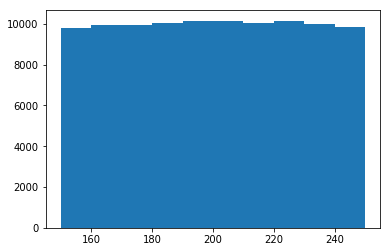

In [2]:
import numpy.random as random
import matplotlib.pyplot as plt

# produce random numbers in the range 150-250
a = 100*random.random(int(1e5))+150
plt.hist(a)
plt.show()

## Analytical Method

The above transformation is a special case of the method described in this section.  We can consider a random number generator that produces values x over the interval $(x_1, x_2)$ with probability $P(x)$, which we wish to convert to values y on the interval $(y_1, y_2)$, with probability $P'(y)$.  To construct a transformation from a generated value $x_{in}$ to an output value with the required distribution, $y_{out}$, we require that the cumulative distributions are equal :

$$\int_{x_0}^{x_{in}} P(x) dx = \int_{y_0}^{y_{out}} P'(y) dy$$

Note that for $x_{in} = x_2$, $y_{out} = y_2$ both integrals must equal 1.

If the LHS of the above equation is uniform on the interval $[0,1)$, then we have :

$$x_{in} = \int_{y_0}^{y_{out}} P'(y) dy$$

If we then define the function $Q(y_{out})$ such that :

$$Q(y_{out}) = x_{in} = \int_{y_0}^{y_{out}} P'(y) dy$$

Then the transformation we must apply to $x_{in}$, in order to obtain $y_{out}$, is simply the inverse function, ie :

$$y_{out} = Q^{-1}(x_{in})$$

### Analytical Method Example

In this example, we will write a function to produce values $y$ in the interval $[0, \pi)$ with probability distribution proportional to $\sin(x)$.

Here, the integral above becomes :

\begin{align}
Q(y_{out}) &= \frac{1}{2}\int_{0}^{y_{out}} \sin(y) dy \\
           &= -\frac{1}{2}\cos(y_{out}) + C
\end{align}

Note the factor $\frac{1}{2}$ is required to ensure the integral from $0$ to $\pi$ is equal to 1.  We can determine the constant of integration by requiring that $Q(0) = 0$, for $x_{in}=0$ and $Q(\pi)=1$ for $x_{in}=1$.

We then find that 

$$Q(y_{out}) = -\frac{1}{2}\cos(y_{out}) + \frac{1}{2}$$

And our inverse transformation is :

$$y_{out} = Q^{-1}(x_{in}) = \cos^{-1}(1-2x_{in}) $$


In [3]:
def randSinAna():
    """Generate a random theta between 0 and pi, with PDF sin(theta) using analytical method"""
    x = random.random()
    return np.arccos(1-2*x)

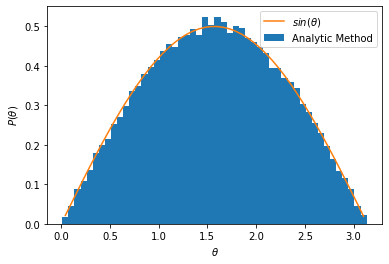

In [42]:
import numpy as np

# generate 50,000 points using a list comprehension
n1s = [randSinAna() for _ in range(50000)]

# plot a histogram
hist1, bins1, patches1 = plt.hist(n1s, bins=50, density=True, label="Analytic Method")

# plot a sin(theta) function for comparison
bin_centres = (bins1[1:] + bins1[:-1])/2
plt.plot(bin_centres, np.sin(bin_centres)/2, label=r'$sin(\theta)$')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')
plt.legend()
plt.show()

It might be worth highlighing the method used here (and in examples below) to generate a large number of points.  This is a _list comprehension_.  The list is generated by calling the first argument in the square brackets (here `randSinAna()`) for every iteration of the for loop.  The for loop uses the underscore instead of a loop variable, since no variable is required.  But in other cases, one could use a standard for loop to generate values in a list, eg :

In [59]:
[i for i in range(5)]

[0, 1, 2, 3, 4]

## Accept/Reject Method

For some PDFs, the integral required by the previous method cannot be determined analytically.  In such cases, the accept/reject method provides a simple alternative.  This method involves three steps :
1. a random number, $y$, is generated in the desired interval $(y_1, y_2)$
2. a second random number, $p$, is generated between 0 and the maximum value of $P'(y)$
3. if $p < P'(y)$ then $y$ is returned, otherwise it is rejected and the process is repeated

This method is clearly less efficient than the analytical method, since two random numbers are generated for each number returned, and some fraction of these are rejected. However, it allows us to generate any arbitrary probability distribution.

### Accept/Reject Example

Here we demonstrate the accept/reject method for the same example as above, to produce values $y$ in the interval $[0, \pi)$, with probability distribution proportional to $\sin(y)$.

In [5]:
def randSinAR():
    """Generate a random theta between 0 and pi, with PDF sin(theta) using accept/reject method"""
    while True:
        x = np.pi * np.random.random()
        y = np.random.random()
        if y < np.sin(x):
            return x
        else:
            continue

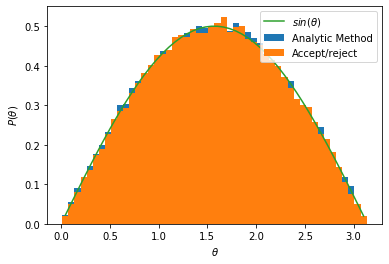

In [40]:
# generate 50,000 points using a list comprehension
n2s = [randSinAR() for _ in range(50000)]

# plot a histogram from the analytic method
hist1, bins1, patches1 = plt.hist(n1s, bins=50, density=True, label="Analytic Method")

# plot another histogram from the accept/reject method
hist2, bins2, patches2 = plt.hist(n2s, bins=bins1, density=True, label="Accept/reject")

# and the sin(theta) function for comparison
plt.plot(bin_centres, np.sin(bin_centres)/2, label=r'$sin(\theta)$')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')
plt.legend()
plt.show()

## Further Analysis

It is interesting to further analyse the results obtained from our example code.

First, we can verify that the generated distributions are comparable to the desired $\sin(x)$ PDF by considering the residuals.

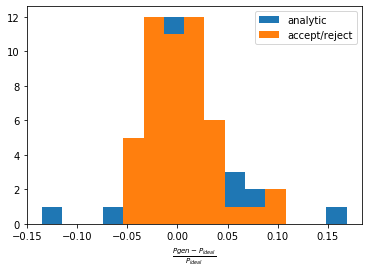

Analytic      : residual mean = 3.42e-03, std dev = 4.33e-02
Accept/reject : residual mean = 4.41e-03, std dev = 3.30e-02


In [7]:
# calculate residuals wrt ideal function
rs1 = 2*hist1/np.sin(bin_centres) - 1
rs2 = 2*hist2/np.sin(bin_centres) - 1

histr1, binsr1, patches = plt.hist(rs1, bins=15, label="analytic")
plt.hist(rs2, bins=binsr1, label='accept/reject')
plt.legend()
plt.xlabel(r'$\frac{P{gen} - P_{ideal}}{P_{ideal}}$')
plt.show()

print("Analytic      : residual mean = {0:.2e}, std dev = {1:.2e}".format(np.mean(rs1), np.std(rs1)))
print("Accept/reject : residual mean = {0:.2e}, std dev = {1:.2e}".format(np.mean(rs2), np.std(rs2)))

This is qualitatively similar to a Normal distribution, and the mean values are clearly compatible with zero within 1 sigma. The standard deviation is approximately what we expect given that we have on average 1000 events per bin, corresponding to a Poisson error of 3%.

Finally, we can also examine the cpu time required by each method.

In [46]:
# cpu time
from timeit import Timer

# time 10,000 calls to each function, and repeat 3 times
# see Code Performance notebook for more details
n = int(1e5)
t_ana  = min(Timer(lambda : randSinAna()).repeat(number=n, repeat=3))/n
t_ar   = min(Timer(lambda : randSinAR()).repeat(number=n, repeat=3))/n
t_acos = min(Timer(lambda : np.arccos(0.5)).repeat(number=n, repeat=3))/n

print()
print("Mean time analytic = {0:.2e} s".format(t_ana))
print("Mean time AR       = {0:.2e} s".format(t_ar))
print("Mean time arccos   = {0:.2e} s".format(t_acos))


Mean time analytic = 1.54e-06 s
Mean time AR       = 3.54e-06 s
Mean time arccos   = 9.20e-07 s


The accept/reject method is slower, as expected.  A minimum two calls to np.random.random() are required to per number produced.  The actual number of calls is somewhat higher, since the while loop will occasionally require 4 calls, or more.  However, the results obtained suggest accept/reject is a factor 1.9 slower than the analytic method.  This is consistent with the `arccos()` call taking a significant fraction (about half) of the time taken by the analytic method.

## Multivariate Distributions

Both analytic and accept/reject methods can be used to generate distributions of more than one variable. This often requires a bit of thought - the two methods may be more or less suitable to particular problems.

### Unit Disc Example - Accept/Reject
Suppose we want to randomly generate points $(x,y)$ within a unit disc.  A simple approach is to generate uniform distributions of $x$ and $y$ separately, and then use an accept/reject method to remove any points not in the disc (ie. where $\sqrt{x^2 + y^2} \gt 1$).  This is illustrated in the example below.

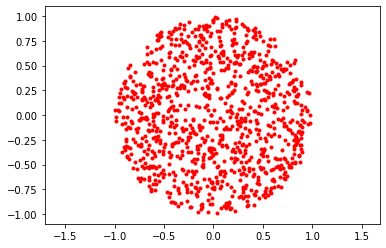

In [65]:
def unitDiscAR():
    x = 2 * np.random.random() - 1
    y = 2 * np.random.random() - 1
    while math.sqrt(x**2+ y**2) > 1:
        x = 2 * np.random.random() - 1
        y = 2 * np.random.random() - 1
    return np.array([x, y])

ps = np.array([unitDiscAR() for _ in range(1000)])

plt.axis('equal')
plt.scatter(ps[:,0], ps[:,1], marker='.', c='r')
plt.show()

Note that since the `unitDisc()` method returns a vector, we need to :
1. convert the list generated by the list comprehension (which calls `unitDisc()` many times) into a 2D array
2. use array slicing to obtain arrays of $x$ and $y$ values separately when plotting, ie. `ps[:,0]` gives a 1D array of $x$ values.

### Unit Disc - Analytic Method

An analytic method for the unit disc problem needs to ensure that the density of points is constant over the disc, ie that $P(x,y) \propto dA$ for area element $dA$. In polar coordinates, we can write this as :

$$P(x,y) \propto dA = r dr d\phi$$

Since we will start by generating values with uniform distributions (let's say $u$ and $v$), we want to obtain transformations $(u,v) \rightarrow (r, \phi)$ such that :

$$dA = r dr d\phi= du dv$$

Clearly these substitutions are sufficient :

$$du = r dr$$
$$dv = d\phi$$

Clearly we can just generate $\phi$ with a uniform distribution.  The function to produce $r$ from uniformly distributed $u$ is obtained by integration  :

$$u = \frac{1}{2}r^2$$

and

$$r = \sqrt{2u}$$

However, this will produce a disc with incorrect area.  The required area is $\pi$, so we can obtain the constant of integration by requiring $\int dA = \pi$, which gives :

$$r = \sqrt{u}$$

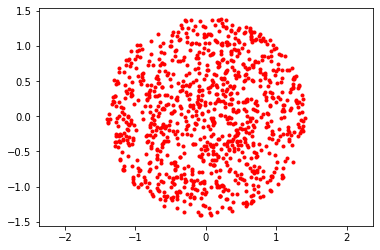

In [66]:
def unitDiscAna():
    phi = 2 * math.pi * np.random.random()
    r = math.sqrt(2*np.random.random())
    
    # convert to cartesian coordinates
    x = r * math.cos(phi)
    y = r * math.sin(phi)
    
    return np.array([x, y])

ps = np.array([unitDiscAna() for _ in range(1000)])

plt.axis('equal')
plt.scatter(ps[:,0], ps[:,1], marker='.', c='r')
plt.show()